# Aims
- Code a PyTorch version of self-organizing maps
- We use a rectangular array of *neurons* as our self-organizing map

# Load libraries

In [1]:
import torch

import numpy as np
import pandas as pd
from functools import partial
import datetime as dt
import pickle as pk

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D

from torchvision.datasets import MNIST

sns.set_style("whitegrid")

# Load data

In [6]:
raw_data = MNIST(root="./data", download=True)
raw_test_data = MNIST(root="./data", download=True, train=False)

data =raw_data.data.numpy().reshape((-1, (28*28))) / 256
test_data = raw_test_data.data.numpy().reshape((-1, (28*28))) / 256

labels = raw_data.targets
test_labels = raw_test_data.targets

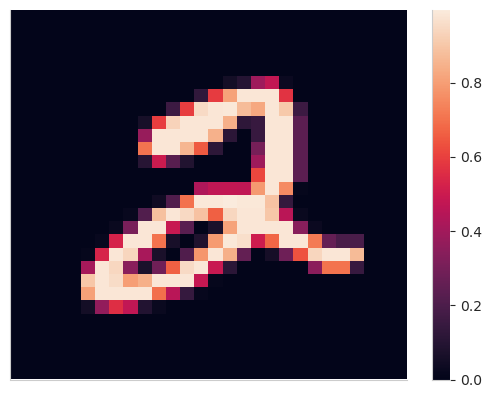

In [7]:
sns.heatmap(data[5].reshape((28, 28)))
sns.despine()
_ = plt.gca().set_xticklabels([])
_ = plt.gca().set_yticklabels([])

# Experiment parameters
- We have a (50x50) array of *neurons*

In [8]:
nrows = 50
ncols = 50
nfeats = data.shape[-1]
nsamples = data.shape[0]

# Create the grid coordinates

In [5]:
rowcoords = np.arange(nrows).reshape((nrows, 1)).repeat(ncols, axis=1)
colcoords = np.arange(ncols).reshape((1, ncols)).repeat(nrows, axis=0)

coords = torch.tensor(np.stack([rowcoords, colcoords], axis=2))

# Set up the weights that will map each data sample to a neuron

In [6]:
W = torch.tensor(np.random.normal(size=(nfeats,nrows, ncols)))

# Define functions

In [7]:
def winner(x, w):
    
    delta = ((x.view((-1, 1, 1)) - W)**2).sum(axis=0)
    
    idx = torch.argwhere(delta == delta.min())
    
    return idx.squeeze()

def neighbourhood_factor(winner_neuron, radius, coords):
    
    delta = coords - winner_neuron.view((1, 1, 2))

    dist2 = (delta**2).sum(axis=2)

    return torch.exp(-0.5 * dist2 / radius**2)

def adjust_weights(neighbourhood_factor, x, W):
    
    return neighbourhood_factor * (x.view((-1, 1, 1)) - W)

# Training parameters

In [8]:
max_epochs = 200
lam = 0.95
R = np.max([nrows, ncols])

lr = 0.5
lr_decay = 0.95

In [9]:
if torch.cuda.is_available():
    
    coords = coords.to(0)
    W = W.to(0)
    data = torch.tensor(data).to(0)

# Train

In [10]:
W_res = []

start_time = dt.datetime.now()

for epoch in range(max_epochs):
    
    for j, x in enumerate(data):
        
        neighbourhood = neighbourhood_factor(winner(x, W), R, coords)
        
        W = W + (lr * adjust_weights(neighbourhood, x, W))
    
    print("Epoch {} complete. Radius: {}. Learning Rate: {}".format(epoch + 1, R, lr))
    
    R *= lam
    lr *= lr_decay
    
    all_winners = np.array([winner(torch.tensor(_).to(0), W).cpu().numpy() for _ in test_data])
    all_winners_df = pd.DataFrame({"x": all_winners[:,0], "y": all_winners[:,1], "label": test_labels})
    W_res.append((epoch, W, all_winners_df))
    
    if (R < 0.5) or (lr < 0.005):
        
        break

print("Training ended. Total time taken: {}".format(dt.datetime.now() - start_time))

with open("outputs/results.pk", "wb") as f:
    
    pk.dump(W_res, f)

Epoch 1 complete. Radius: 50. Learning Rate: 0.5
Epoch 2 complete. Radius: 47.5. Learning Rate: 0.475
Epoch 3 complete. Radius: 45.125. Learning Rate: 0.45125
Epoch 4 complete. Radius: 42.86875. Learning Rate: 0.42868749999999994
Epoch 5 complete. Radius: 40.725312499999994. Learning Rate: 0.40725312499999994
Epoch 6 complete. Radius: 38.689046874999995. Learning Rate: 0.38689046874999994
Epoch 7 complete. Radius: 36.75459453124999. Learning Rate: 0.3675459453124999
Epoch 8 complete. Radius: 34.91686480468749. Learning Rate: 0.34916864804687486
Epoch 9 complete. Radius: 33.17102156445311. Learning Rate: 0.3317102156445311
Epoch 10 complete. Radius: 31.512470486230455. Learning Rate: 0.31512470486230454
Epoch 11 complete. Radius: 29.93684696191893. Learning Rate: 0.2993684696191893
Epoch 12 complete. Radius: 28.440004613822982. Learning Rate: 0.2844000461382298
Epoch 13 complete. Radius: 27.01800438313183. Learning Rate: 0.2701800438313183
Epoch 14 complete. Radius: 25.66710416397524. L

# Looking at how each data sample is mapped to the neuron array at the end of training
- We can see that samples from each digit is mapped into a tight cluster in the neuron array (with some exceptions)
- This shows that the competitive learning algorithm manages to cluster the samples quite efficiently

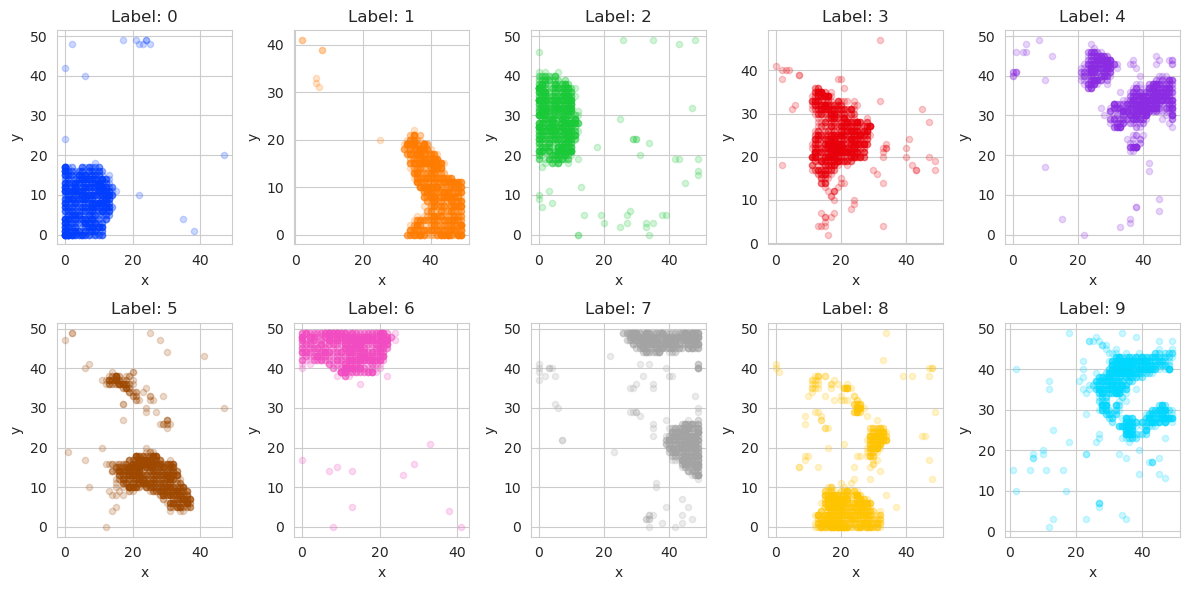

In [71]:
f, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 6))

colors = sns.color_palette("bright", 10)

for (i, j), a in zip(df.groupby("label"), ax.ravel()):
    
    j.plot(kind="scatter", x="x", y="y", ax=a, alpha=0.2, color=colors[i])
    
    a.set_title("Label: {}".format(i))
    
plt.tight_layout()

f.savefig("outputs/activation_maps.png")

# Comparing the maps at the start and end of training
- At Epoch 1, we see that the samples are mapped into very similar coordinates
- This can also be seen by the histogram showing the number of unique digits being mapped to each neuron (right panel)
  - We can see that many of the neurons have more than one digit mapped to it

- At Epoch 90, the samples are mapped al over the neuron array and are well separated

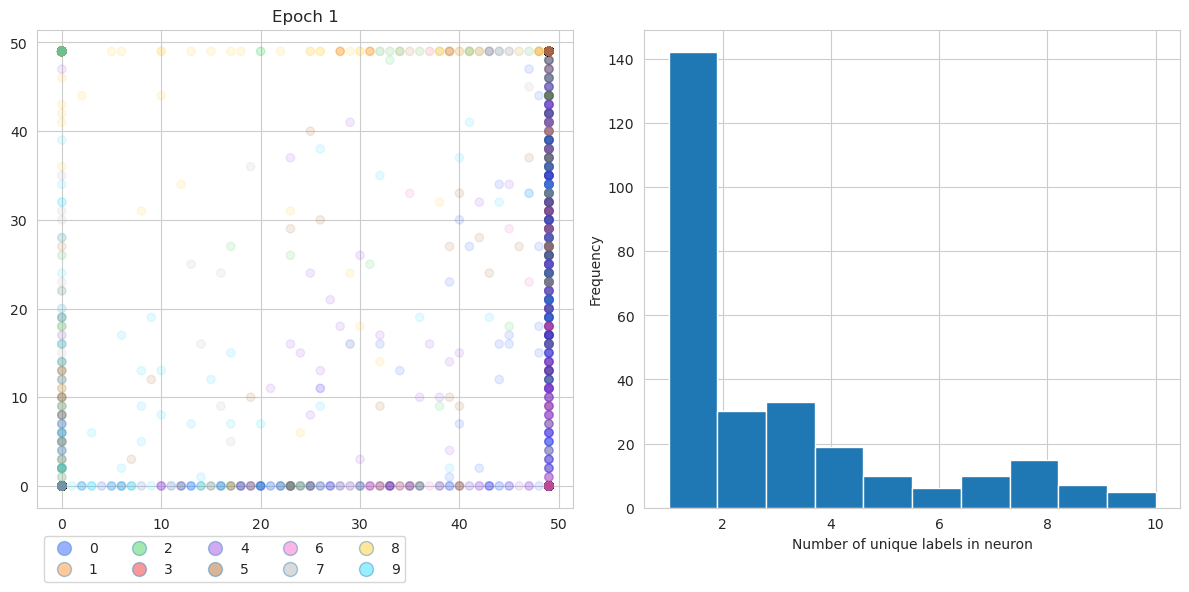

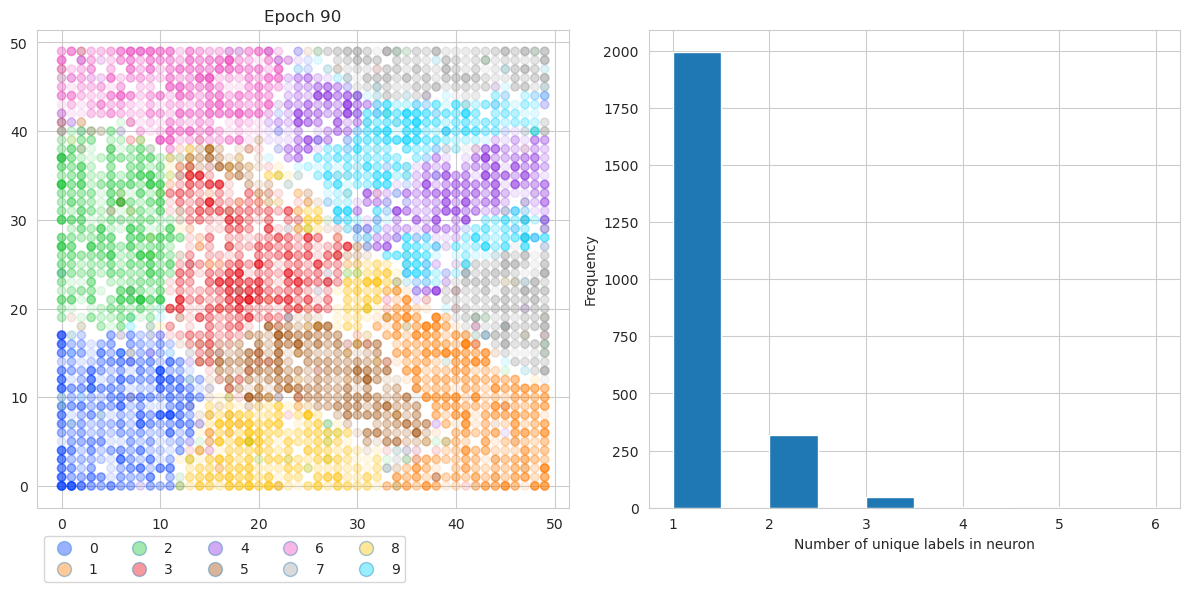

In [13]:
colors = sns.color_palette("bright", 10)

for epoch, W, all_winners_df in [W_res[0], W_res[-1]]:
    f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    ax[0].scatter(all_winners_df.x, all_winners_df.y, c=[colors[_] for _ in test_labels.cpu().numpy().astype(int)], alpha=0.1)
    
    legend_elements = [Line2D([0], [0], marker="o", linewidth=0, label=_, markerfacecolor=colors[_], markersize=10, alpha=0.4) for _ in range(10)]
    ax[0].legend(handles = legend_elements, fancybox=True, ncols=5, bbox_to_anchor=(0, -0.17, 1, 1))
    unique_dist = all_winners_df.groupby(["x", "y"]).apply(lambda x: x.label.nunique())
    unique_dist.plot(kind="hist", ax=ax[1])
    ax[1].set_xlabel("Number of unique labels in neuron")
    ax[0].set_title(f"Epoch {epoch + 1}")
    plt.tight_layout()
    
    f.savefig(f"outputs/activation_dist_epoch{epoch+1}.png")

# Lookng at neurons with 6 digits mapped to it
- Notice that there is one neuron with 6 digits mapped to it
- It is the neuron at (0, 41).
- Why? It is unclear, but the digits seem a little slanted/blurred, especially the "6" at the bottom right panel

In [82]:
unique_dist.loc[unique_dist == 6]

x  y 
0  41    6
dtype: int64

In [83]:
max_labels_neuron = all_winners_df.loc[(all_winners_df.x == 0) & (all_winners_df.y == 41)]

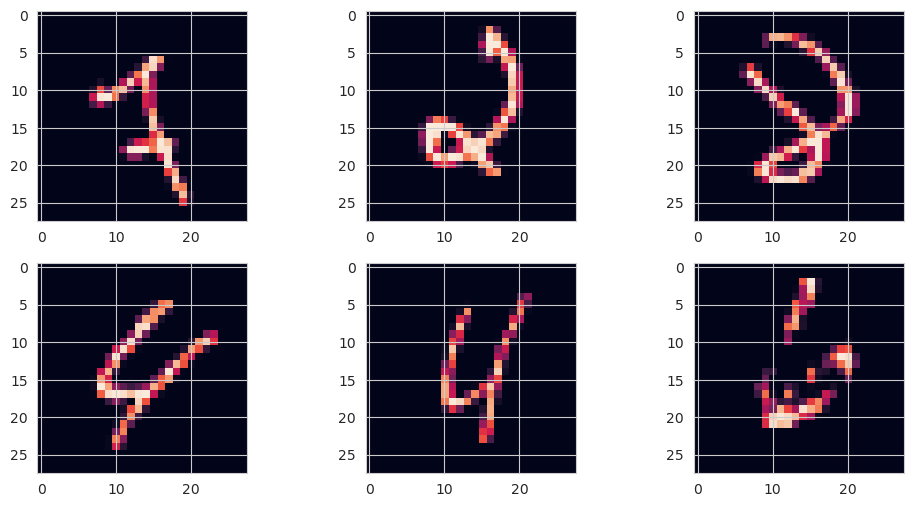

In [84]:
f, ax = plt.subplots(nrows=2, ncols=3, figsize=(12,6))

for i, a in zip(max_labels_neuron.index, ax.ravel()):
    
    a.imshow(test_data[i].reshape((28,28)))